
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Мария Мансурова, аналитик-разработчик в команде Яндекс.Метрики. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание № 9. (демо)
## <center> Анализ временных рядов
    
**Заполните пропущенный код и ответьте на вопросы в [онлайн-форме](https://docs.google.com/forms/d/1ijk4aFKY5plPiI8z3Mgi3i1Ln94VBY9SSt6xGIdVVFQ/).**

In [1]:
import os

import pandas as pd
import requests
from plotly import __version__
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot

import datetime
from sklearn.metrics import mean_absolute_error
import numpy as np

print(__version__)  # need 1.9.0 or greater

init_notebook_mode(connected=True)


def plotly_df(df, title=""):
    data = []

    for column in df.columns:
        trace = go.Scatter(x=df.index, y=df[column], mode="lines", name=column)
        data.append(trace)

    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

4.14.3


## Подготавливаем данные

Для начала скачаем данные в `dataframe`. Сегодня будем предсказывать просмотры wiki-страницы [Machine Learning](https://en.wikipedia.org/wiki/Machine_learning). Данные я скачала с помощью библиотеки [Wikipediatrend](https://www.r-bloggers.com/using-wikipediatrend/) для `R`.

In [2]:
df = pd.read_csv("wiki_machine_learning.csv", sep=" ")
df = df[df["count"] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [3]:
df.shape

(383, 7)

In [4]:
df['date'] = pd.to_datetime(df['date'])

In [5]:
plotly_df(df.set_index("date")[["count"]])

## Предсказание с помощью Facebook Prophet

Для начала построим предсказание с помощью простой библиотеки `Facebook Prophet`. Для того, чтобы посмотреть на качество модели, отбросим из обучающей выборки последние 30 дней.

In [6]:
from fbprophet import Prophet

In [7]:
predictions = 30

df = df[["date", "count"]]
df.columns = ["ds", "y"]
train_df = df[:-predictions].copy()

In [8]:
Pr = Prophet()
Pr.fit(train_df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
future = Pr.make_future_dataframe(periods = predictions)
forecast = Pr.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-01,2483.544508,2094.388623,2849.962483
1,2015-01-02,2166.505710,1783.648288,2589.121136
2,2015-01-03,1300.580631,897.594791,1708.500491
3,2015-01-04,1444.407112,1057.830876,1847.209186
4,2015-01-05,2449.365508,2053.441939,2859.715710
...,...,...,...,...
378,2016-01-16,2109.459185,1682.964336,2518.355212
379,2016-01-17,2255.737598,1851.925843,2667.376734
380,2016-01-18,3263.147928,2795.037067,3652.226469
381,2016-01-19,3528.386289,3127.148341,3890.929770


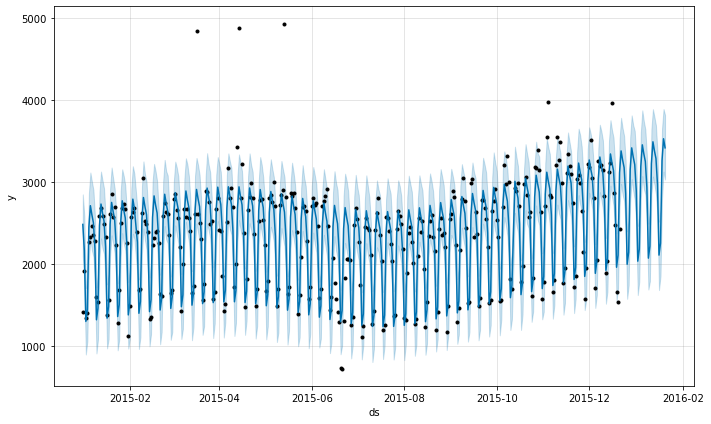

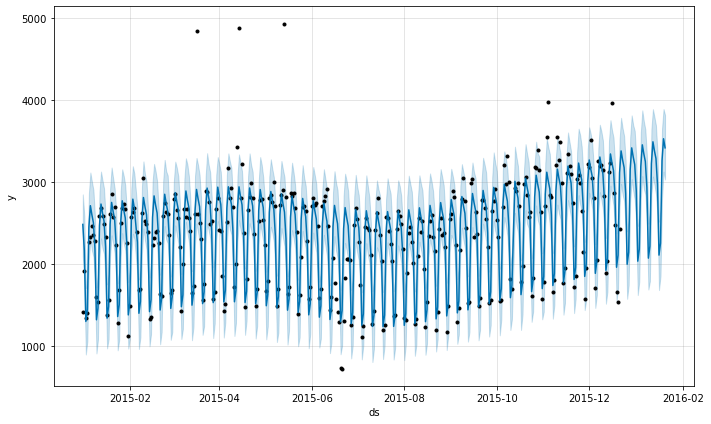

In [10]:
Pr.plot(forecast)

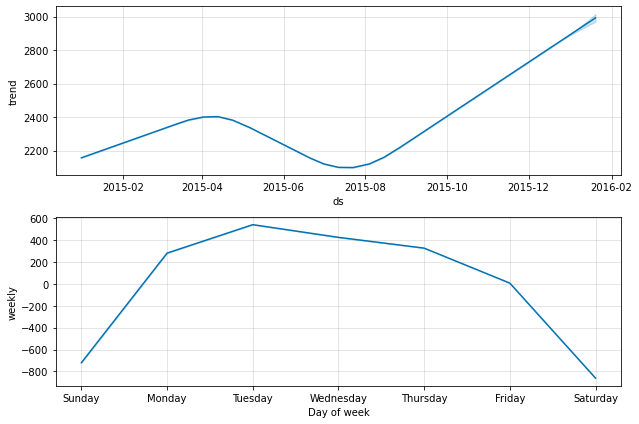

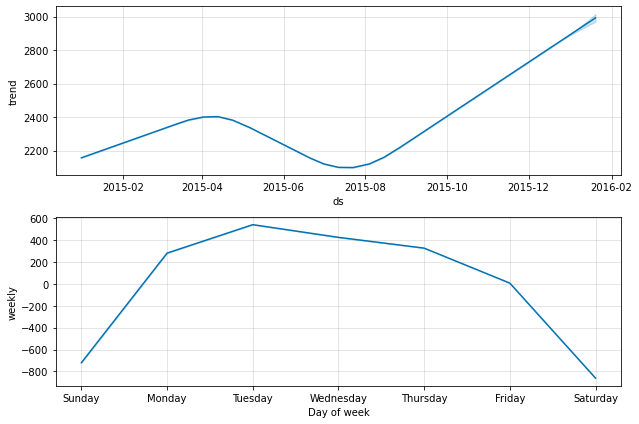

In [11]:
Pr.plot_components(forecast)

**Вопрос 1:** Какое предсказание числа просмотров wiki-страницы на 20 января? Ответ округлите до целого числа.

Оценим качество предсказания по последним 30 точкам.

In [12]:
round(forecast[forecast['ds'] == '2016-01-20']['yhat'])

382    3418.0
Name: yhat, dtype: float64

In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(abs(y_true - y_pred) / y_true)

In [14]:
## ВАШ КОД для оценки качества полученной модели ##
MAPE = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
MAE = mean_absolute_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])

**Вопрос 2**: Какое получилось MAPE?

**Вопрос 3**: Какое получилось MAE?

In [15]:
print(f'MAPE = {MAPE}')
print(f'MAE = {MAE}')

MAPE = 0.3419380159794991
MAE = 593.3705390372357


## Предсказываем с помощью ARIMA

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

**Вопрос 4:** Проверим стационарность ряда с помощью критерия Дики-Фулера. Является ли ряд стационарным? Какое значение p-value?

In [17]:
## ВАШ КОД для проверки стационарности ряда ##
sm.tsa.stattools.adfuller(df['y'])[1]

0.015383668419468997

**Вопрос 5**: Далее перейдем к построению модели SARIMAX (`sm.tsa.statespace.SARIMAX`). Модель c какими параметрами лучшая по `AIC`-критерию?

In [18]:
from itertools import product

p = range(0, 5)
d = 1
q = range(0, 4)
P = range(0, 5)
D = 1
Q = range(0, 1)
s = 7

In [19]:
%%time
## ВАШ КОД для построения модели ##
from tqdm.notebook import tqdm_notebook
import warnings
warnings.filterwarnings('ignore')

best_model = None
best_param = None
best_AIC = float('inf')
models = list()

params = product(p, q, P, Q)

for param in tqdm_notebook(params):
    try:
        model = sm.tsa.statespace.SARIMAX(df['y'], 
                                          order = (param[0], d, param[1]), 
                                          seasonal_order = (param[2], D, param[3], s)).fit(disp = False)
    except:
        print(f'Wrong param: {param}')
        continue
    
    models.append(model)
    AIC = model.aic
    
    if AIC < best_AIC:
        best_AIC = AIC
        best_model = model
        best_param = param
        
    

Wrong param: (2, 2, 4, 0)

Wall time: 4min 56s


In [29]:
print(f'Best AIC: {best_AIC}')
print(f'Best parameters: {best_param}')

Best AIC: 5471.413311571384
Best parameters: (3, 1, 3, 0)


In [30]:
%%time
# навчаємо модель із кращими параметрами але із більшим інтервалом сезонності

best_param_model = sm.tsa.statespace.SARIMAX(df['y'], 
                                          order = (best_param[0], d, best_param[1]), 
                                          seasonal_order = (best_param[2], D, best_param[3], 7*7)).fit(disp = False)

Wall time: 6min 2s


In [34]:
print(f'Best AIC: {best_param_model.aic}')
best_param_model.summary()

Best AIC: 5058.664281646811


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  383
Model:             SARIMAX(3, 1, 1)x(3, 1, [], 49)   Log Likelihood               -2521.332
Date:                             Sat, 20 Feb 2021   AIC                           5058.664
Time:                                     12:33:12   BIC                           5089.129
Sample:                                          0   HQIC                          5070.812
                                             - 383                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4618      0.058      7.921      0.000       0.347       0.576
ar.L2         -0.1769      0.057     -3.111      0.002      -0.288      -0.065
ar.L3          0.0103      0.065      0.159      0.874      -0.117       0.138
ma.L1         -0.8930      0.038    -23.786      0.000      -0.967      -0.819
ar.S.L49      -0.5359      0.057     -9.415      0.000      -0.647      -0.424
ar.S.L98      -0.3569      0.088     -4.041      0.000      -0.530      -0.184
ar.S.L147     -0.1166      0.068     -1.726      0.084      -0.249       0.016
sigma2      2.109e+05   1.41e+04     14.980      0.000    1.83e+05    2.38e+05
===================================================================================
Ljung-Box (Q):                      227.68   Jarque-Bera (JB):                58.93
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.32
Prob(H) (two-sided):                  0.77   Kurtosis:                         4.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""